In [ ]:
# 1. Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import copy

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# 2. Data Loading & Preprocessing

# Load the dataset (Assuming file is uploaded to Colab root)
try:
    df = pd.read_csv('/content/kc_house_data.csv')
    print("Dataset loaded.")
except FileNotFoundError:
    print("Error: 'kc_house_data.csv' not found. Please upload the file.")

# Feature Engineering
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract useful time features
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month

# Calculate House Age and Renovation Age
df['house_age'] = df['sale_year'] - df['yr_built']
df['years_since_renovation'] = df['sale_year'] - df['yr_renovated'].apply(lambda x: x if x > 0 else df['sale_year'][0])
# Handle negative values if any (renovated after sale date logic)
df['years_since_renovation'] = df['years_since_renovation'].apply(lambda x: 0 if x < 0 else x)

# Drop non-numeric or redundant columns
# 'id' is just an identifier. 'date' is processed.
cols_to_drop = ['id', 'date']
df_clean = df.drop(columns=cols_to_drop)

# Define Features (X) and Target (y)
X = df_clean.drop(columns=['price'])
y = df_clean['price']

# Split Data into Train, Validation, and Test
# 70% Train, 15% Validation, 15% Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=SEED) # 0.1765 of 85% is ~15%

# Scaling Data (Important for Deep Learning and Linear Models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert targets to numpy arrays
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

print(f"Training Shape: {X_train_scaled.shape}")
print(f"Validation Shape: {X_val_scaled.shape}")
print(f"Test Shape: {X_test_scaled.shape}")

Dataset loaded.
Training Shape: (15128, 22)
Validation Shape: (3243, 22)
Test Shape: (3242, 22)


In [ ]:
# 3. Classical Machine Learning Implementation

results_classical = {}

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {name} Results ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

# --- Model 1: Ridge Regression (Linear Model with Regularization) ---
print("\nTraining Ridge Regression...")
ridge = Ridge()
params_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0]}
grid_ridge = GridSearchCV(ridge, params_ridge, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train_scaled, y_train)

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)
results_classical['Ridge Regression'] = evaluate_model("Ridge Regression", y_test, y_pred_ridge)

# --- Model 2: Random Forest Regressor ---
print("\nTraining Random Forest (this may take a minute)...")
rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
# Reduced grid for speed in demonstration, expand for production
params_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(rf, params_rf, cv=3, scoring='neg_mean_squared_error')
grid_rf.fit(X_train_scaled, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
results_classical['Random Forest'] = evaluate_model("Random Forest", y_test, y_pred_rf)

print("\nBest Hyperparameters for Random Forest:", grid_rf.best_params_)


Training Ridge Regression...
--- Ridge Regression Results ---
RMSE: 216894.20
MAE: 127274.06
R2 Score: 0.6918

Training Random Forest (this may take a minute)...
--- Random Forest Results ---
RMSE: 137182.92
MAE: 72742.88
R2 Score: 0.8767

Best Hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}



Starting Deep Learning Training...
Epoch 10/100, Train Loss: 318525893034, Val Loss: 304304913204
Epoch 20/100, Train Loss: 77422047559, Val Loss: 53467301833
Epoch 30/100, Train Loss: 26822778644, Val Loss: 17769433885
Epoch 40/100, Train Loss: 26506889791, Val Loss: 16598624520
Epoch 50/100, Train Loss: 24451090654, Val Loss: 16656339977
Early stopping at epoch 51
--- Deep Learning (PyTorch) Results ---
RMSE: 141599.27
MAE: 78873.48
R2 Score: 0.8686


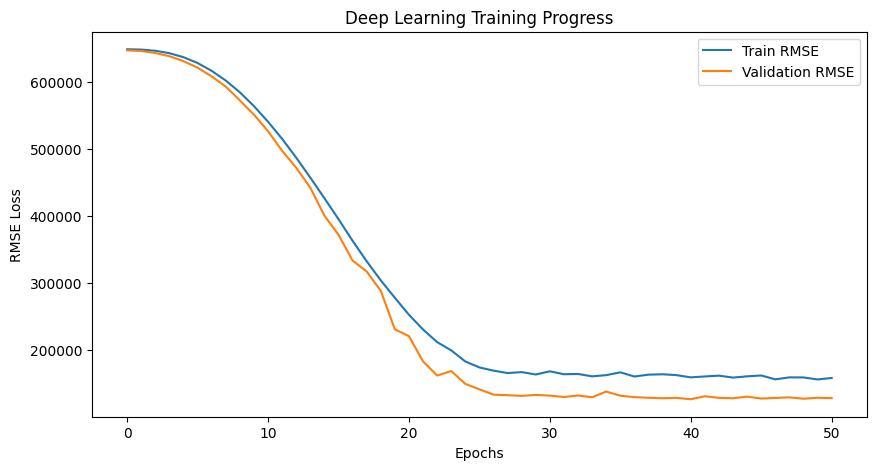

In [ ]:
# 4. Deep Learning Implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import copy
import matplotlib.pyplot as plt

# Convert data to PyTorch Tensors
class HouseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HouseDataset(X_train_scaled, y_train)
val_dataset = HouseDataset(X_val_scaled, y_val)
test_dataset = HouseDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Neural Network Architecture
# This network uses fully connected layers with Batch Normalization and Dropout for regularization

class HousePriceNN(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1) # Output layer for regression
        )

    def forward(self, x):
        return self.network(x)

# Initialize Model
input_dim = X_train_scaled.shape[1]
model = HousePriceNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# FIXED LINE: Removed 'verbose=True' to resolve TypeError
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop with Early Stopping
# The loop iterates through data, calculates loss, and updates weights via backpropagation

num_epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0
best_model_weights = copy.deepcopy(model.state_dict())
train_losses = []
val_losses = []

print("\nStarting Deep Learning Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    # Scheduler step
    scheduler.step(epoch_val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.0f}, Val Loss: {epoch_val_loss:.0f}")

    # Early Stopping Check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_weights)

# Evaluate on Test Set
model.eval()
y_pred_dl = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_pred_dl.extend(outputs.view(-1).tolist())

y_pred_dl = np.array(y_pred_dl)
# Assuming 'evaluate_model' and 'results_classical' are defined in previous cells
if 'results_classical' in globals() and 'evaluate_model' in globals():
    results_classical['Deep Learning'] = evaluate_model("Deep Learning (PyTorch)", y_test, y_pred_dl)
else:
    print("Evaluation function not found. Printing basic stats:")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dl)):.2f}")

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(np.sqrt(train_losses), label='Train RMSE')
plt.plot(np.sqrt(val_losses), label='Validation RMSE')
plt.title('Deep Learning Training Progress')
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()


--- Model Comparison Summary ---
                           RMSE            MAE        R2
Ridge Regression  216894.198786  127274.060638  0.691762
Random Forest     137182.923747   72742.882439  0.876692
Deep Learning     141599.271493   78873.477382  0.868625


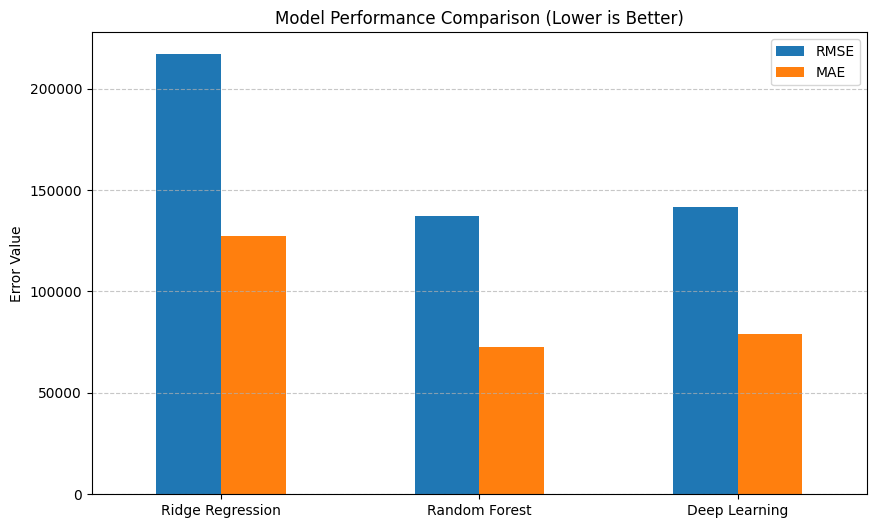

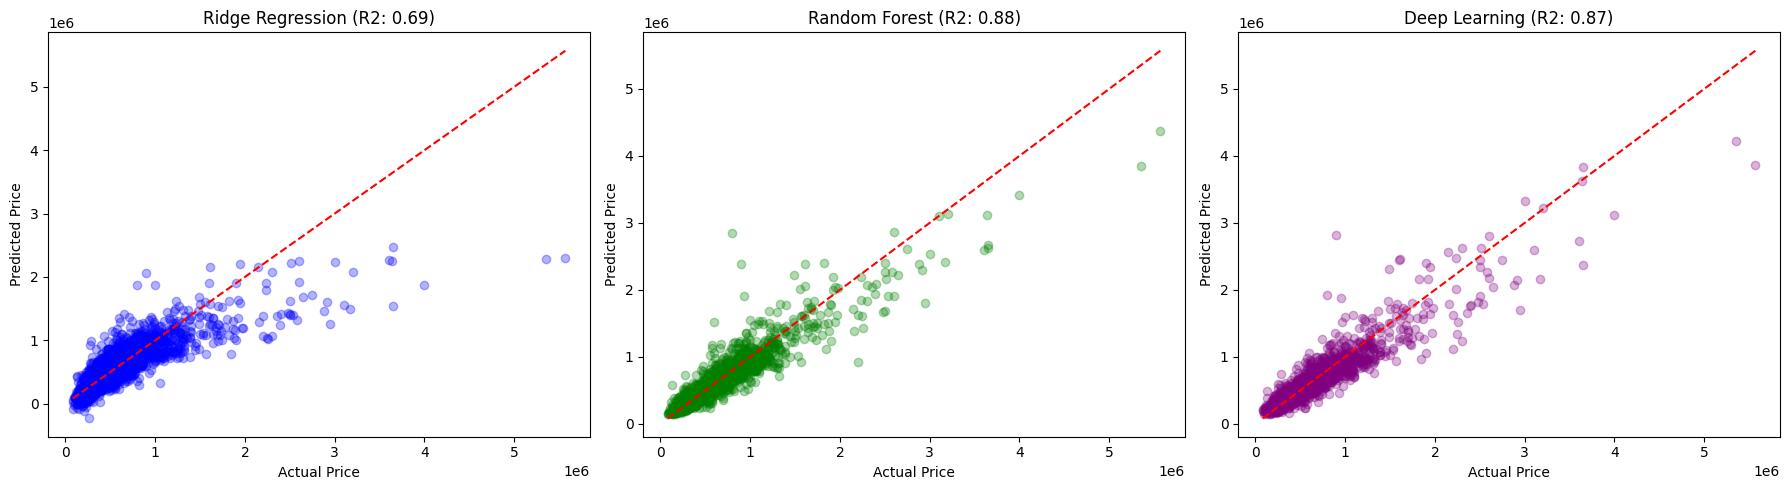

In [ ]:
# 5. Comparative Analysis & Visualization

# Create DataFrame for Comparison
results_df = pd.DataFrame(results_classical).T
print("\n--- Model Comparison Summary ---")
print(results_df)

# Plot Comparison
fig, ax = plt.subplots(figsize=(10, 6))
results_df[['RMSE', 'MAE']].plot(kind='bar', ax=ax)
plt.title('Model Performance Comparison (Lower is Better)')
plt.ylabel('Error Value')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(18, 5))

# Ridge
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Ridge Regression (R2: {results_classical["Ridge Regression"]["R2"]:.2f})')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Random Forest (R2: {results_classical["Random Forest"]["R2"]:.2f})')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Deep Learning
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_dl, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Deep Learning (R2: {results_classical["Deep Learning"]["R2"]:.2f})')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.tight_layout()
plt.show()